In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import comb
import math
import concurrent.futures


In [2]:
def open_image(img_path):
    img = cv2.imread(img_path)
    return img


def get_gray_img_mat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def expand_image(img, expanded_size, kernel_size, ratio=2):
    # Create the expanded image with zeros
    expanded_img = np.zeros(expanded_size)
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / (weights / 4)
    # Upsample the input image
    # Adjust the slicing to match the desired size exactly
    expanded_img[:img.shape[0] * ratio:ratio, :img.shape[1] * ratio:ratio] = img
    # Perform the blur
    expanded_img = np.round(convolve(expanded_img, kernel))
    return expanded_img


def convolve(image, kernel):
    # Perform the convolution using scipy.signal.convolve2d
    result = convolve2d(image, kernel, mode='same', boundary='symm')
    return result


# create a function that returns the gaussian kernel for a given size and the total sum of the kernel
# for example ofr size=5 return kernel = np.array([[1, 4, 6, 4, 1],
# [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]]) and weight = 256
def get_gaussian_kernel(size):
    # Calculate the kernel
    n = math.floor(size)
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = comb(n - 1, i) * comb(n - 1, j)

    # Normalize the kernel to make the sum an integer
    kernel_sum = np.sum(kernel)
    kernel_factor = int(np.ceil(kernel_sum))
    kernel = (kernel * kernel_factor / kernel_sum).astype(int)

    return kernel, kernel_factor


def reduce_image(img, reduced_img_size, kernel_size=5, should_blur=True):
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / weights
    # Perform the blur
    if should_blur:
        img = np.round(convolve(img, kernel))

    # Use array slicing and reshaping to select every second element
    reduced_img = img[:reduced_img_size[0] * 2:2, :reduced_img_size[1] * 2:2]

    return reduced_img


def get_reduced_size(img, factor=2):
    return img.shape[0] // factor, img.shape[1] // factor


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1]))) - 1


# @measure_time
def create_pyramid(img, kernel_size, scale = 10):
    pyramid = []
    pyramid.append({'G': img})
    reduced_img = img
    level = min(get_max_level(img), scale+1)
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size, kernel_size)
        expanded_image_size = pyramid[i - 1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size, kernel_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})

    for i in range(len(pyramid) - 1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i + 1]['Expanded_G']
    pyramid[-1]['L'] = pyramid[-1]['G']
    return pyramid

def get_mask_pyramid(mask):
    mask = np.ceil(mask / 255)
    mask_pyramid = []
    mask_pyramid.append({'G': mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid


def get_images_for_feature_matching(img_high_res_gray, img_low_res_gray, scale):
    high_res_pyramid = create_pyramid(img_high_res_gray, gaussian_kernel_size, scale)
    low_res_pyramid = create_pyramid(img_low_res_gray, gaussian_kernel_size, scale)
    
    high_res_img = cv2.normalize(high_res_pyramid[scale]['G'], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    low_res_img = cv2.normalize(low_res_pyramid[scale]['G'], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    return high_res_img, low_res_img


def get_original_coordinates(points, scale):
    return points * (2 ** scale)


def get_colored_img_high_res_wrapped(colored_img_high_res, H):
    h, w = colored_img_high_res.shape[:2]
    colored_img_warped = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(3):
        colored_img_warped[:, :, i] = cv2.warpPerspective(colored_img_high_res[:, :, i], H, (w, h))
    return colored_img_warped



def blend_pyramids(pyramid1, pyramid2, mask_pyramid, max_level=100):
    blended_pyramid = []
    i = 0
    max_level = min(max_level, len(pyramid1))
    for i in range(max_level - 1):
        blended_pyramid.append(
            {'L': pyramid1[i]['L'] * mask_pyramid[i]['G'] + (1 - mask_pyramid[i]['G']) * pyramid2[i]['L']})
    # the last level is blended differently
    blended_pyramid.append(
        {'L': pyramid1[i + 1]['G'] * mask_pyramid[i + 1]['G'] + (1 - mask_pyramid[i + 1]['G']) * pyramid2[i + 1]['G']})
    return blended_pyramid

def reconstruct_image(pyramid, kernel_size):
    reconstructed_img = pyramid[-1]['L']
    for i in range(len(pyramid) - 2, -1, -1):
        expanded_img = expand_image(reconstructed_img, pyramid[i]['L'].shape, kernel_size)
        reconstructed_img = expanded_img + pyramid[i]['L']
    return reconstructed_img


def blend_images(img1, img2, mask, max_level, kernel_size):
    with (concurrent.futures.ThreadPoolExecutor()):
        img1_pyramid_a, img1_pyramid_b, img1_pyramid_c = create_pyramid(img1[:, :, 0], kernel_size), create_pyramid(
            img1[:, :, 1], kernel_size), create_pyramid(img1[:, :, 2], kernel_size)
        img2_pyramid_a, img2_pyramid_b, img2_pyramid_c = create_pyramid(img2[:, :, 0], kernel_size), create_pyramid(
            img2[:, :, 1], kernel_size), create_pyramid(img2[:, :, 2], kernel_size)
        mask_pyramid = get_mask_pyramid(mask)
        blended_pyramid_a = blend_pyramids(img1_pyramid_a, img2_pyramid_a, mask_pyramid, max_level)
        blended_pyramid_b = blend_pyramids(img1_pyramid_b, img2_pyramid_b, mask_pyramid, max_level)
        blended_pyramid_c = blend_pyramids(img1_pyramid_c, img2_pyramid_c, mask_pyramid, max_level)
    reconstructed_img_a = reconstruct_image(blended_pyramid_a, kernel_size)
    reconstructed_img_b = reconstruct_image(blended_pyramid_b, kernel_size)
    reconstructed_img_c = reconstruct_image(blended_pyramid_c, kernel_size)
    
    #normalize the image
    reconstructed_img_a = cv2.normalize(reconstructed_img_a, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    reconstructed_img_b = cv2.normalize(reconstructed_img_b, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    reconstructed_img_c = cv2.normalize(reconstructed_img_c, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    return np.dstack((reconstructed_img_a, reconstructed_img_b, reconstructed_img_c))





# hyper parameters
scale_for_feature_matching = 2
gaussian_kernel_size = 5
ratio_1nn_to_2nn = 0.8
max_error_for_homography = 5


def ex4(img_high_res_path, img_low_res_path):
    # open the images
    colored_img_high_res = open_image(img_high_res_path)
    colored_img_low_res = open_image(img_low_res_path)
    # convert the images to gray scale
    img_high_res_gray = get_gray_img_mat(colored_img_high_res)
    img_low_res_gray = get_gray_img_mat(colored_img_low_res)       
    # create the pyramids (gaussian and laplacian) for the images

    
    # get the images for feature matching
    img_high_res_gray, img_low_res_gray = get_images_for_feature_matching(img_high_res_gray, img_low_res_gray, scale_for_feature_matching)
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_high, des_high = sift.detectAndCompute(img_high_res_gray, None)
    kp_low, des_low = sift.detectAndCompute(img_low_res_gray, None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_high, des_low, k=2)
    
    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < ratio_1nn_to_2nn * n.distance:
            good.append(m)
     
     
    # Extract keypoints from good matches
    kp_high_matched = [kp_high[m.queryIdx] for m in good]
    kp_low_matched = [kp_low[m.trainIdx] for m in good]
    
    # covnert keypoints to numpy arrays
    src_pts = np.float32([kp.pt for kp in kp_high_matched]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp.pt for kp in kp_low_matched]).reshape(-1, 1, 2)
    
    src_pts = get_original_coordinates(src_pts, scale_for_feature_matching)
    dst_pts = get_original_coordinates(dst_pts, scale_for_feature_matching)
    
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, max_error_for_homography)
    colored_high_img_wraped = get_colored_img_high_res_wrapped(colored_img_high_res, H)
    mask = (colored_high_img_wraped != 0).astype(np.uint8)[:,:, 0]
    
    blended_image = blend_images(colored_high_img_wraped, colored_img_low_res, mask, 2, gaussian_kernel_size)
    return blended_image


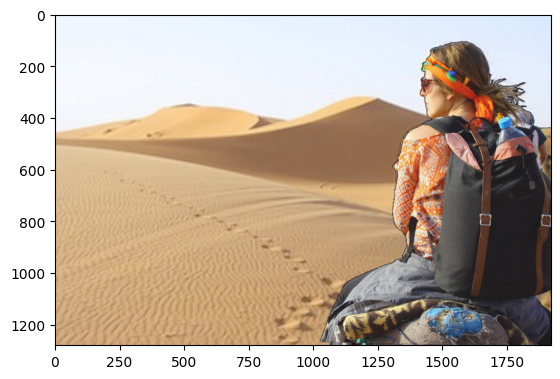

In [3]:
# img_low_res_path = './assets/lake_low_res.jpg'
# img_high_res_path = './assets/lake_high_res.png'

img_high_res_path = './assets/desert_high_res.png'
img_low_res_path = './assets/desert_low_res.jpg'

blended_image = ex4(img_high_res_path, img_low_res_path)
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))